In [102]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split,KFold
import lightgbm as lgb

from sklearn.metrics import roc_curve,auc

train=pd.read_csv("./data/zhengqi_train.txt",sep='\t')# V0-V37, target
test=pd.read_csv("./data/zhengqi_test.txt",sep='\t')

# train=train.drop(['V5','V22','V17', 'V11', 'V21', 'V9', 'V27', 'V20', 'V23', 'V14','V2','V35', 'V19', 'V6', 'V7', 'V13','V28'], axis = 1)
# test=test.drop(['V5','V22','V17', 'V11', 'V21', 'V9', 'V27', 'V20', 'V23', 'V14','V2','V35', 'V19', 'V6', 'V7', 'V13','V28'], axis = 1)

X_train=np.array(train.drop(['target'], axis = 1))#(2888, 38)
y_train=np.array(train['target'])#(2888,)
X_test=np.array(test)#(1925,38)

# 训练集测试集一致性检查
假设----
训练集的label设置为0，测试集的label设置为1，训练出一个分类器，如果模型训练出来auc为0.1，即分类器识别不出训练集和测试集，说明训练集可以代表测试集，否则训练集测试集相差较大

实际上---
auc是0.99989？？？？,训练集和测试集相差这么大的？？？？

## 发现训练集和测试集分布差距很大

In [103]:
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor

X_auc=np.r_[X_train,X_test]
y_auc=np.r_[np.zeros(2888),np.ones(1925)]

folds=5
avg_cv_score=0

kf=KFold(n_splits=folds,shuffle=True,random_state=2022)
for i, (train_index,test_index) in enumerate(kf.split(X_auc)):
    lgb=RandomForestClassifier()
    lgb.fit(X_auc[train_index],y_auc[train_index])
    y_pred_lgb=lgb.predict_proba(X_auc[test_index])
    fpr,tpr,thresholds=roc_curve(y_auc[test_index],y_pred_lgb[:,1])
    score=auc(fpr,tpr)
    print("-----sklearn:",score)
    
    avg_cv_score+=score
avg_cv_score/=5
print('avg score=',avg_cv_score)


-----sklearn: 0.9997799947917134
-----sklearn: 0.9995572342501897
-----sklearn: 0.9999052953432368
-----sklearn: 0.9997211514437663
-----sklearn: 0.9998850092669003
avg score= 0.9997697370191613


## 选择验证集，使得验证集和测试集分布相差不大

In [178]:
believe_id=np.where(y_train_pred[:,1]>0.04)
no_believe_id=np.where(y_train_pred[:,1]<=0.04)

y_auc=np.r_[np.zeros(465),np.ones(1925)]

my_train  =np.r_[X_train[believe_id],X_test]
my_train_y=np.r_[np.zeros(465),np.ones(1925)]

In [179]:
# X_auc_train, X_auc_test, y_auc_train, y_auc_test = train_test_split(X_auc, y_auc, test_size=0.3, random_state=2022)

model_lgb=RandomForestClassifier()
model_lgb.fit(my_train,my_train_y)
y_auc_test_pred=model_lgb.predict_proba(my_train)
score=auc(my_train_y, y_auc_test_pred[:,1])
print("-----sklearn:",score)

-----sklearn: 0.544


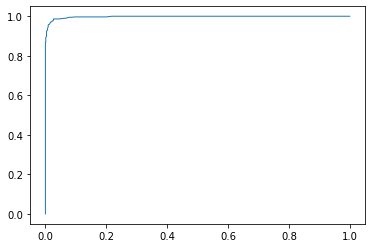

In [86]:
import matplotlib.pyplot as plt
plt.plot(fpr, tpr, linewidth=1,label="auc")

## 训练模型，根据验证集表现调参

In [151]:
auc_train_X=X_train[no_believe_id]
auc_train_y=y_train[no_believe_id]
auc_valid_X=X_train[believe_id]
auc_valid_y=y_train[believe_id]

In [153]:
y_train

array([0.175, 0.676, 0.633, ..., 0.005, 0.35 , 0.417])

In [155]:
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
model_lgb=RandomForestRegressor()
model_lgb.fit(auc_train_X,auc_train_y)
y_auc_test_pred=model_lgb.predict(auc_valid_X)
mean_squared_error(y_auc_test_pred,auc_valid_y)

0.14309776955204306

In [157]:
result=model_lgb.predict(X_test)
pd.DataFrame(result).to_csv('result_20220509.txt',index=False,header=False)# 得分：0.1401 真的线上线下超符合！！！！！！！

# 实验一下其他模型

In [166]:
from xgboost import XGBRegressor
model_lgb=XGBRegressor()
model_lgb.fit(auc_train_X,auc_train_y)

y_auc_test_pred=model_lgb.predict(auc_train_X)
print('训练集: ',mean_squared_error(y_auc_test_pred,auc_train_y))

y_auc_test_pred=model_lgb.predict(auc_valid_X)
print('验证集: ',mean_squared_error(y_auc_test_pred,auc_valid_y))

训练集:  0.000896899237393862
验证集:  0.15138862900004021


In [165]:
from lightgbm import LGBMRegressor 
model_lgb=LGBMRegressor()
model_lgb.fit(auc_train_X,auc_train_y)

y_auc_test_pred=model_lgb.predict(auc_train_X)
print('训练集: ',mean_squared_error(y_auc_test_pred,auc_train_y))

y_auc_test_pred=model_lgb.predict(auc_valid_X)
print('验证集: ',mean_squared_error(y_auc_test_pred,auc_valid_y))

训练集:  0.015545593104977008
验证集:  0.1384134149903684


In [162]:
result=model_lgb.predict(X_test)
pd.DataFrame(result).to_csv('result_20220509_lgb.txt',index=False,header=False)

In [176]:
from sklearn.linear_model import LinearRegression
model_lgb=LinearRegression()
model_lgb.fit(auc_train_X,auc_train_y)

y_auc_test_pred=model_lgb.predict(auc_train_X)
print('训练集: ',mean_squared_error(y_auc_test_pred,auc_train_y))

y_auc_test_pred=model_lgb.predict(auc_valid_X)
print('验证集: ',mean_squared_error(y_auc_test_pred,auc_valid_y))

训练集:  0.10318206927627373
验证集:  0.13237079748896724


In [177]:
result=model_lgb.predict(X_test)
pd.DataFrame(result).to_csv('result_20220509_lr.txt',index=False,header=False)##3.1364 我是真搞不懂

In [175]:
from lightgbm import LGBMRegressor 
model_lgb=LGBMRegressor()
eval_set=[(auc_valid_X,auc_valid_y)]

model_lgb.fit(auc_train_X,auc_train_y,sample_weight=y_train_pred[no_believe_id,1].reshape(-1),eval_set=eval_set)

y_auc_test_pred=model_lgb.predict(auc_train_X)
print('训练集: ',mean_squared_error(y_auc_test_pred,auc_train_y))

y_auc_test_pred=model_lgb.predict(auc_valid_X)
print('验证集: ',mean_squared_error(y_auc_test_pred,auc_valid_y))

[1]	valid_0's l2: 1.05169
[2]	valid_0's l2: 0.894947
[3]	valid_0's l2: 0.763378
[4]	valid_0's l2: 0.65926
[5]	valid_0's l2: 0.571761
[6]	valid_0's l2: 0.50066
[7]	valid_0's l2: 0.445419
[8]	valid_0's l2: 0.395986
[9]	valid_0's l2: 0.355604
[10]	valid_0's l2: 0.320993
[11]	valid_0's l2: 0.293195
[12]	valid_0's l2: 0.268274
[13]	valid_0's l2: 0.246927
[14]	valid_0's l2: 0.230493
[15]	valid_0's l2: 0.216695
[16]	valid_0's l2: 0.206344
[17]	valid_0's l2: 0.195174
[18]	valid_0's l2: 0.187337
[19]	valid_0's l2: 0.181637
[20]	valid_0's l2: 0.174628
[21]	valid_0's l2: 0.170468
[22]	valid_0's l2: 0.166533
[23]	valid_0's l2: 0.163482
[24]	valid_0's l2: 0.160727
[25]	valid_0's l2: 0.15852
[26]	valid_0's l2: 0.155633
[27]	valid_0's l2: 0.154749
[28]	valid_0's l2: 0.153038
[29]	valid_0's l2: 0.151363
[30]	valid_0's l2: 0.150399
[31]	valid_0's l2: 0.149783
[32]	valid_0's l2: 0.149336
[33]	valid_0's l2: 0.148393
[34]	valid_0's l2: 0.14806
[35]	valid_0's l2: 0.147731
[36]	valid_0's l2: 0.146787
[37]	v